In [15]:
from HeaderP import *

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq
from scipy.signal import savgol_filter
from astropy.timeseries import LombScargle



# load simulation

In [16]:
Rcut_thread=25
data=pd.read_pickle('../TNGRbirth/Tobias/g8.26e11.pkl')
data=data.loc[data['Rbir']<Rcut_thread].reset_index(drop=True)
data['R']=np.sqrt(data['x']**2+data['y']**2)


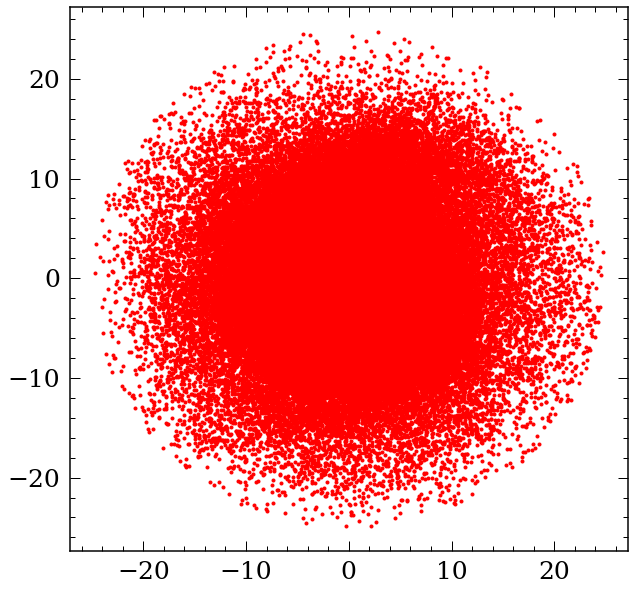

In [17]:
plt.plot(data['x'],data['y'],'r.')

In [18]:
m_sr = (data['Rbir']>7)&(data['Rbir']<9)
data_sr = data[m_sr]

In [19]:
snapshotnames = np.load('../TNGRbirth/Tobias/snapshots.npy')
ages = np.load('../TNGRbirth/Tobias/cosmictime.npy')

In [20]:
agelookup = {snapshotnames[i]:ages[i] for i in range(len(ages))}

In [21]:
xcols = [i for i in data_sr.columns if 'x_' in i] 
ycols = [i for i in data_sr.columns if 'y_' in i] 
zcols = [i for i in data_sr.columns if 'z_' in i] 

xcols = [i for i in xcols if 'vx_' not in i]
ycols = [i for i in ycols if 'vy_' not in i] 
zcols = [i for i in zcols if 'vz_' not in i] 

snaps = [i.split('_')[-1] for i in xcols]

In [22]:
dr = np.zeros(0)
cosmictime = np.zeros(0)
IDs = np.zeros(0)
for i in range(len(snaps)):
    data_snap = data_sr.dropna(subset=[xcols[i],ycols[i]])
    IDs = np.append(IDs, data_snap['iord'])
    R = np.sqrt(data_snap[xcols[i]]**2+data_snap[ycols[i]]**2).values
    Rb = data_snap['Rbir'].values
    dr = np.append(dr, R-Rb)
    cosmictime = np.append(cosmictime, np.ones(len(data_snap))*agelookup[snaps[i]])

In [23]:
print(len(IDs))
IDs = pd.Series(IDs).drop_duplicates(keep='first').values
print(len(IDs))

294001
12292


In [24]:
def SlideMed(age, dr, window, slide):
    age, dr = np.array(age), np.array(dr)
    minage, maxage = min(age), max(age)
    npoints = int((maxage-minage)/slide)
    medage = np.zeros(npoints)*np.nan
    meddr = np.zeros(npoints)*np.nan
    for i in trange(npoints):
        if i==0:
            m_w = (age<window)
        elif i==npoints-1:
            m_w = (age>(maxage-window))
        else:
            m_w = ((age>(i*slide-window+minage))&(age<(i*slide+window+minage)))
        #print(sum(m_w))
        medage[i], meddr[i] = np.median(age[m_w]), np.median(dr[m_w])
    m_nan = (meddr==meddr)
    medage, meddr = medage[m_nan], meddr[m_nan]
    return medage, meddr
        

In [47]:
# get PSD for each star
xfs = np.zeros(0)
PSDs = np.zeros(0)
nums = np.zeros(0)
ages_PSD = np.array([agelookup[j] for j in snaps])

freqs = np.linspace(0.1,1e3,1000)
for i in trange(len(IDs)):
    data_star = data.loc[data['iord']==IDs[i]]
    
    R = np.sqrt(data_star[xcols].values[0]**2+data_star[ycols].values[0]**2)
    drs = R-data_star['Rbir'].values
    
    m = (drs==drs)
    age, drs = ages_PSD[m], drs[m]

    if len(age)<10:
        continue
        
    # do fft
    power = LombScargle(age, drs).power(freqs)
    xfs = np.append(xfs,freqs)
    FFTp = np.array(power, dtype=float)
    PSDs = np.append(PSDs, FFTp**2)
    nums = np.append(nums, len(age)*np.ones(len(FFTp)))


100%|██████████| 12292/12292 [07:13<00:00, 28.33it/s] 


  0%|          | 0/4854 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 4854/4854 [00:00<00:00, 5865.86it/s]


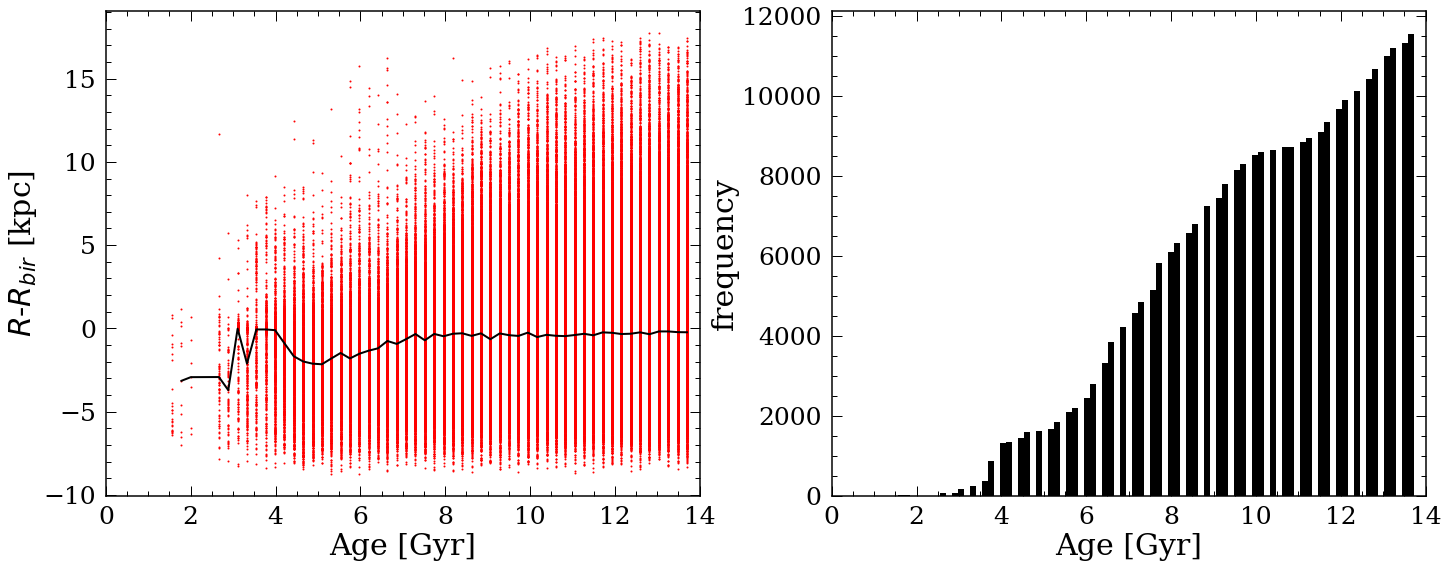

In [48]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
age_order, dr_order = zip(*sorted(zip(cosmictime, dr)))
plt.scatter(age_order, dr_order,s=1,c='r')
age_smooth, dr_smooth = SlideMed(age_order, dr_order, 0.0025/2, 0.0025)
plt.plot(age_smooth, dr_smooth,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,14])

plt.subplot(1,2,2)
plt.hist(age_order,bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,14])
plt.tight_layout()

In [49]:
m = (PSDs==PSDs)
xfs, PSDs, nums = xfs[m], PSDs[m], nums[m]

100%|██████████| 99/99 [00:01<00:00, 69.86it/s]
<ipython-input-113-2b59409e20d6>:11: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([-10,5])


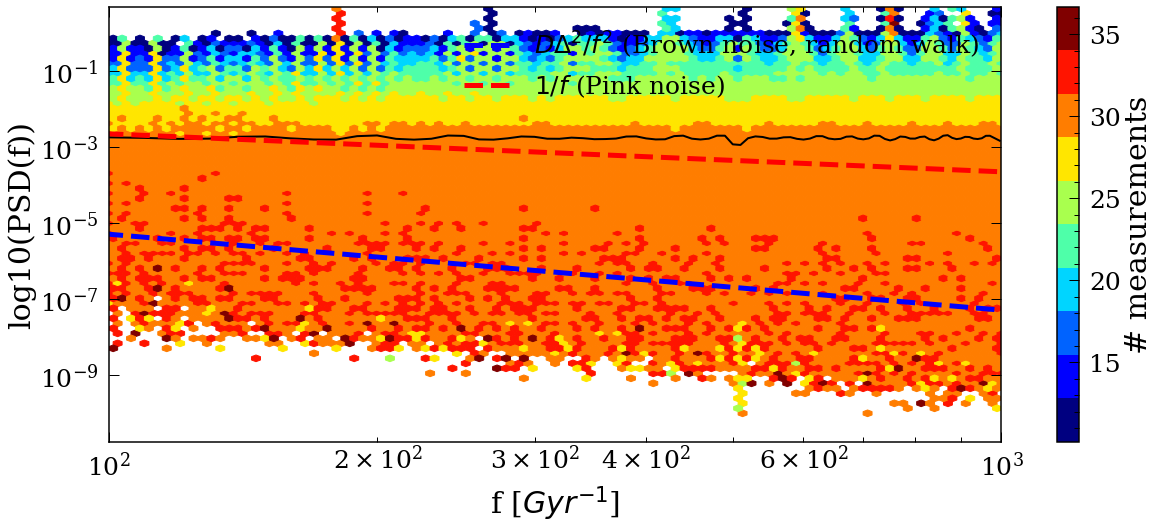

In [113]:
# do every star
plt.figure(figsize=(20,8))
cmap = plt.cm.get_cmap('jet',10)
plt.hexbin(np.array(xfs), np.array(PSDs), C = np.array(nums), yscale='log', xscale='log', extent=(2,3,-10,5),
          mincnt = 10, gridsize=100, cmap=cmap)
xfs_smooth, PSDs_smooth = SlideMed(xfs, PSDs, 10, 10)
plt.loglog(xfs_smooth, PSDs_smooth, 'k-')
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('log10(PSD(f))')
plt.xlim([100,1000])
plt.ylim([-10,5])
cb = plt.colorbar()
cb.set_label('# measurements')

A2 = 1
A1 = 1
plt.plot(xfs_smooth, A2*np.mean(np.diff(ages))**2/xfs_smooth**2, 'b--',label='$DΔ^2/f^2$ (Brown noise, random walk)',linewidth=5)
plt.plot(xfs_smooth, A1*np.mean(np.diff(ages))/xfs_smooth, 'r--',label='$1/f$ (Pink noise)',linewidth=5)

plt.legend()



100%|██████████| 99/99 [00:00<00:00, 9057.79it/s]


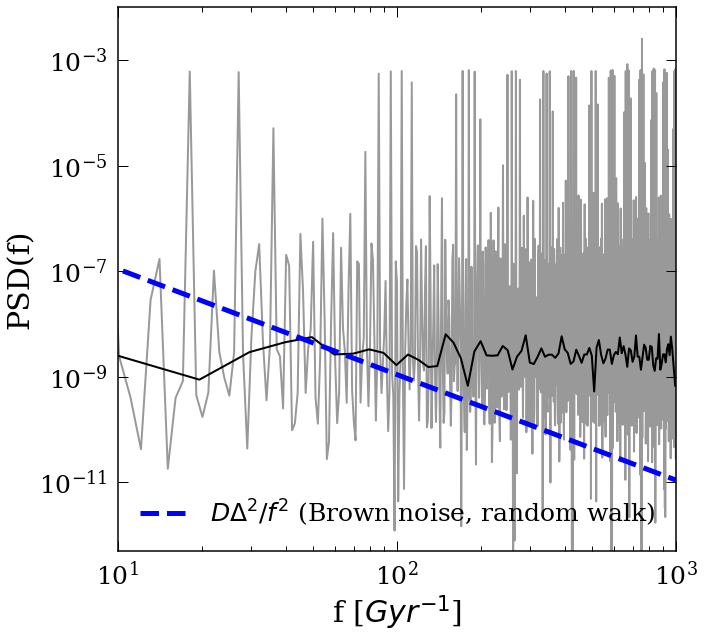

In [145]:
freqs = np.linspace(0.1,1e3,1000)
power = np.array(LombScargle(age_order, dr_order).power(freqs), dtype=float)**2

plt.loglog(freqs,power,'k-',alpha=0.4)

freqs_smooth, power_smooth = SlideMed(freqs, power, 10, 10)
plt.loglog(freqs_smooth, power_smooth,'k-')

Delta = np.mean(np.diff(ages))
D = 1
plt.plot(freqs, D*Delta**2/freqs**2/(len(age_order)/len(ages)), 'b--',label='$DΔ^2/f^2$ (Brown noise, random walk)',linewidth=5)
plt.xlim([10,1e3])
plt.ylim([5e-13,1e-2])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [132]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 14, 1000)
#power = LombScargle(data_sr['age'], data_sr['dR']).power(frequency)
power = LombScargle(age_smooth, dr_smooth).power(2*np.pi/periods)

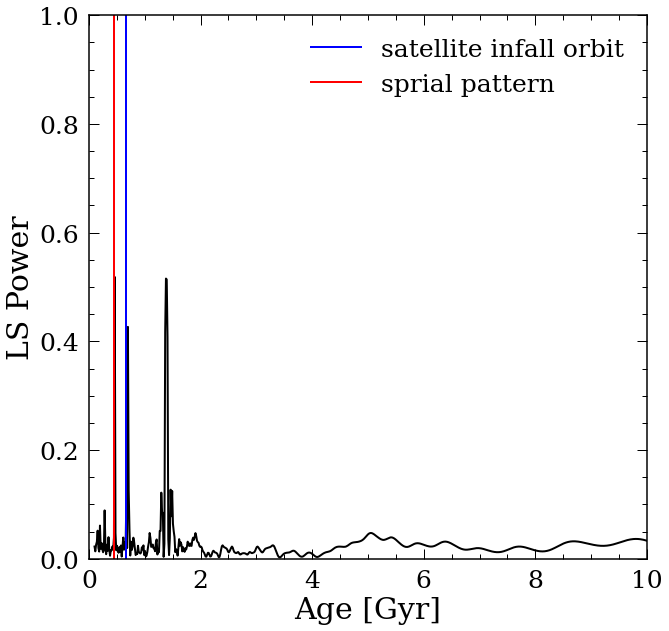

In [133]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,1])
plt.xlim([0,10])
plt.plot([0.66,0.66],[0,1],'b-',label='satellite infall orbit')
plt.plot([0.44,0.44],[0,1],'r-',label='sprial pattern')
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')
plt.legend()

# Use the last snapshot

<ipython-input-134-f44abd308846>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_sr['dR'] = data_sr['R']-data_sr['Rbir']
  0%|          | 0/1298 [00:00<?, ?it/s]/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/homebrew/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1298/1298 [00:00<00:00, 18161.70it/s]


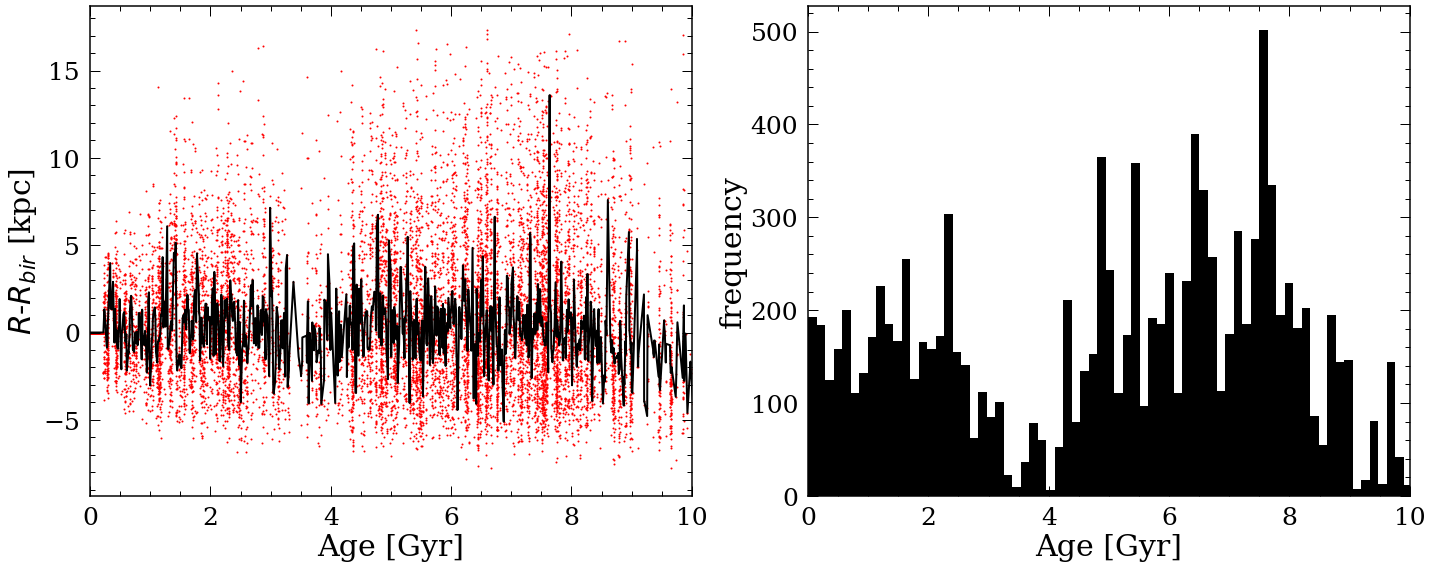

In [134]:
from scipy.ndimage import gaussian_filter1d
plt.figure(figsize=(20,8))
m = ((data['Rbir']>7)&(data['Rbir']<9))
data_sr=data[m]
data_sr['dR'] = data_sr['R']-data_sr['Rbir']
plt.subplot(1,2,1)
age_order_sel, dr_order_sel = zip(*sorted(zip(data_sr['age'],data_sr['dR'])))
plt.scatter(age_order_sel, dr_order_sel,s=1,c='r')
age_smooth_sel, dr_smooth_sel = SlideMed(data_sr['age'].values, data_sr['dR'].values, 0.01, 0.01)
plt.plot(age_smooth_sel, dr_smooth_sel,'k-')
plt.xlabel('Age [Gyr]')
plt.ylabel('$R$-$R_{bir}$ [kpc]')
plt.xlim([0,10])

plt.subplot(1,2,2)
plt.hist(age_order_sel,bins=np.linspace(0,14,100),color='k')
plt.xlabel('Age [Gyr]')
plt.ylabel('frequency')
plt.xlim([0,10])
plt.tight_layout()

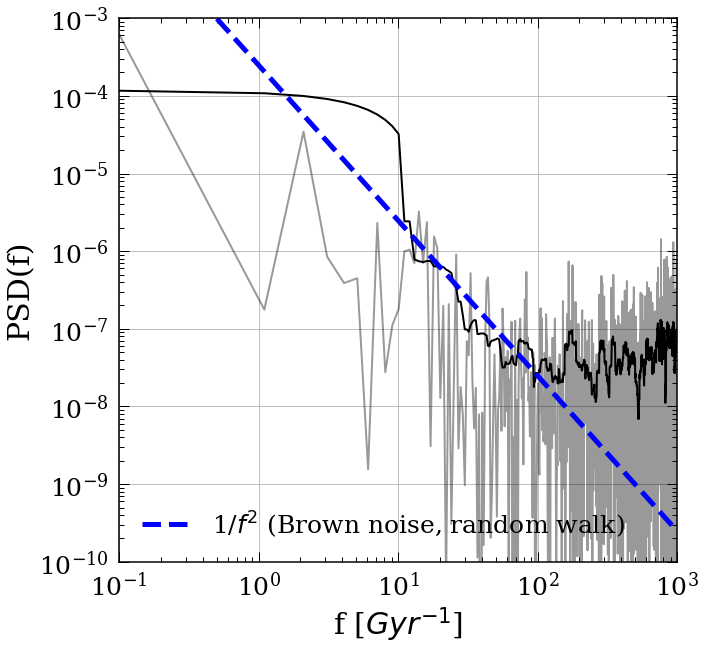

In [144]:

from scipy.ndimage import gaussian_filter1d
from scipy.fft import fft, fftfreq

freqs = np.linspace(0.1,1e3,1000)
power = np.array(LombScargle(age_order_sel, dr_order_sel).power(freqs), dtype=float)**2

plt.loglog(freqs,power,'k-',alpha=0.4)

PSD_smooth_sel = savgol_filter(power, 21, 1)
plt.loglog(freqs,PSD_smooth_sel,'k-')

D = 1
plt.plot(freqs, D*np.mean(np.diff(ages))**2/freqs**2/(len(data_sr)/len(ages)), 'b--',label='1/$f^2$ (Brown noise, random walk)',linewidth=5)
plt.grid()
plt.xlim([1e-1,1e3])
plt.ylim([1e-10,1e-3])
plt.xlabel('f [$Gyr^{-1}$]')
plt.ylabel('PSD(f)')
plt.legend(loc=3)

In [148]:
from astropy.timeseries import LombScargle
periods = np.linspace(0.1, 10, 1000)
power = LombScargle(age_smooth_sel, dr_smooth_sel).power(2*np.pi/periods)

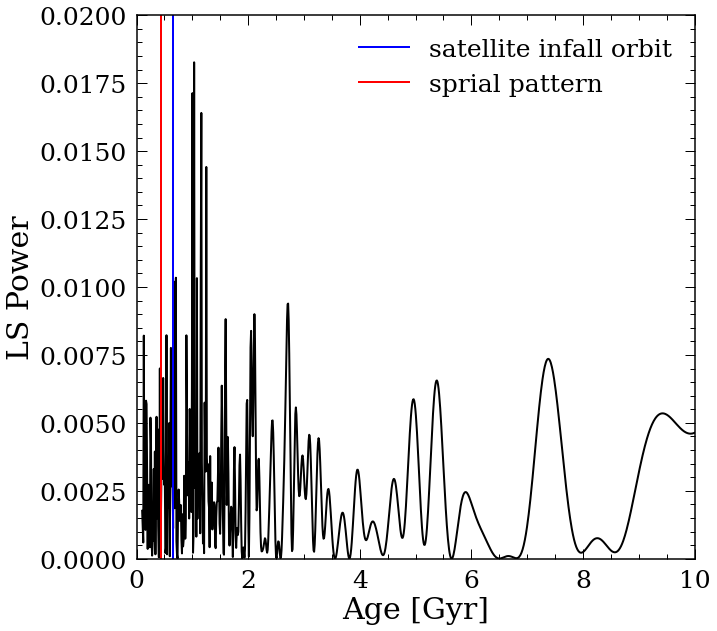

In [152]:
plt.plot(periods, np.array(power,dtype=float),'k-')
plt.ylim([0,0.02])
plt.xlim([0,10])
plt.plot([0.66,0.66],[0,1],'b-',label='satellite infall orbit')
plt.plot([0.44,0.44],[0,1],'r-',label='sprial pattern')
plt.xlabel('Age [Gyr]')
plt.ylabel('LS Power')
plt.legend()

# load merger tree

In [153]:
import ytree

In [160]:
a = ytree.load("../TNGRbirth/Tobias/g8.26e11.01024.parameter", hubble_constant=0.7)


AttributeError: 'AHFDataFile' object has no attribute 'omega_matter'